In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

import env
import wrangle
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score


In [2]:
df = wrangle.get_zillow_data()

In [3]:
df = wrangle.prepare_zillow_data(df)

In [4]:
train, validate, test = wrangle.split_zillow_data(df)

### Create variables for model

In [5]:
X_train = train.drop(columns ='Tax_Appraised_Value')
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns ='Tax_Appraised_Value')
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns ='Tax_Appraised_Value')
y_test = test['Tax_Appraised_Value']


In [32]:
X_train.head()

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Footage,Year_Built,Tax_Assessed,County
2014110,2,2.0,1779,1956,5127.84,Los Angeles County
432230,3,2.0,939,1959,2380.98,Los Angeles County
1724453,4,2.0,1408,1950,4213.56,Los Angeles County
1237258,5,3.0,3069,1989,6146.96,Orange County
2037405,4,4.0,3398,1984,8115.19,Los Angeles County


### Create the baseline

In [7]:
train['yhat_baseline'] = train['Tax_Appraised_Value'].mean()
train.head()

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Footage,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,yhat_baseline
2014110,2,2.0,1779,412297,1956,5127.84,Los Angeles County,460758.592666
432230,3,2.0,939,196290,1959,2380.98,Los Angeles County,460758.592666
1724453,4,2.0,1408,336456,1950,4213.56,Los Angeles County,460758.592666
1237258,5,3.0,3069,612600,1989,6146.96,Orange County,460758.592666
2037405,4,4.0,3398,716009,1984,8115.19,Los Angeles County,460758.592666


### Using scaled data

In [8]:
columns_to_scale = ['Number_of_Bedrooms','Number_of_Bathrooms', 'Square_Footage']

In [9]:
scaler = sklearn.preprocessing.QuantileTransformer(output_distribution='normal')
train_scaled = train.copy()
train_scaled[columns_to_scale] = scaler.fit_transform(train_scaled[columns_to_scale])

In [10]:
train.Tax_Appraised_Value.head()

2014110    412297
432230     196290
1724453    336456
1237258    612600
2037405    716009
Name: Tax_Appraised_Value, dtype: int64

In [11]:
model = LinearRegression().fit(train_scaled[['Square_Footage']], train.Tax_Appraised_Value)
predictions = np.round(model.predict(train_scaled[['Square_Footage']]),2)

In [12]:
train['predictions'] = predictions

In [13]:
train.head()

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Footage,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,yhat_baseline,predictions
2014110,2,2.0,1779,412297,1956,5127.84,Los Angeles County,460758.592666,522151.01
432230,3,2.0,939,196290,1959,2380.98,Los Angeles County,460758.592666,24968.82
1724453,4,2.0,1408,336456,1950,4213.56,Los Angeles County,460758.592666,356390.23
1237258,5,3.0,3069,612600,1989,6146.96,Orange County,460758.592666,851486.10
2037405,4,4.0,3398,716009,1984,8115.19,Los Angeles County,460758.592666,907929.51


In [14]:
# compute residuals
train['residual'] = train['predictions'] - train['Tax_Appraised_Value']
train['residual_baseline'] = train['yhat_baseline'] - train['Tax_Appraised_Value']
train.head()

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Footage,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,yhat_baseline,predictions,residual,residual_baseline
2014110,2,2.0,1779,412297,1956,5127.84,Los Angeles County,460758.592666,522151.01,109854.01,48461.592666
432230,3,2.0,939,196290,1959,2380.98,Los Angeles County,460758.592666,24968.82,-171321.18,264468.592666
1724453,4,2.0,1408,336456,1950,4213.56,Los Angeles County,460758.592666,356390.23,19934.23,124302.592666
1237258,5,3.0,3069,612600,1989,6146.96,Orange County,460758.592666,851486.10,238886.10,-151841.407334
2037405,4,4.0,3398,716009,1984,8115.19,Los Angeles County,460758.592666,907929.51,191920.51,-255250.407334


Text(0, 0.5, 'y = Tax Appraised Value')

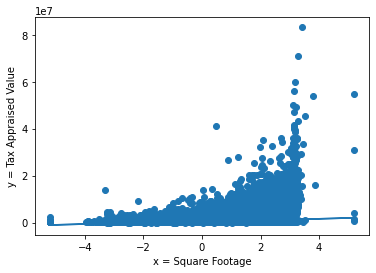

In [33]:
plt.scatter(train_scaled.Square_Footage, train.Tax_Appraised_Value)
plt.plot(train_scaled.Square_Footage, train.predictions)
plt.xlabel('x = Square Footage')
plt.ylabel('y = Tax Appraised Value')


Residuals


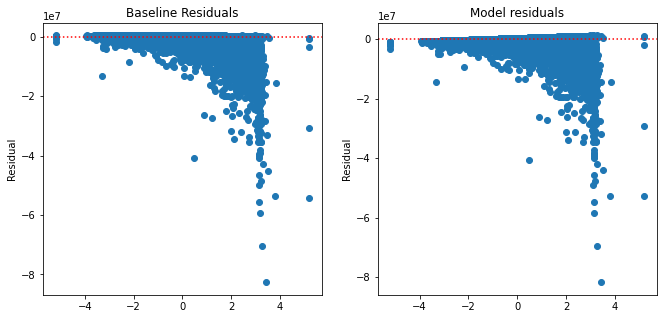

In [37]:
# residual plots (x vs residual)

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(train_scaled.Square_Footage, train.residual_baseline)
plt.axhline(y = 0, ls = ':', color='red')
plt.ylabel('Residual')
plt.title('Baseline Residuals')

plt.subplot(122)
plt.scatter(train_scaled.Square_Footage, train.residual)
plt.axhline(y = 0, ls = ':', color='red')
plt.ylabel('Residual')
plt.title('Model residuals');

In [39]:
train.residual.min(), train.residual.max()

(-81758091.57, 1295113.42)

#### Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.

#### SSE

In [38]:
SSE = mean_squared_error(train.Tax_Appraised_Value, train.predictions)*len(train)
SSE_baseline = mean_squared_error(train.Tax_Appraised_Value, train.yhat_baseline)*len(train)

print("SSE sklearn: ", SSE) 
print("SSE sklearn(baseline): ", SSE_baseline) 

SSE sklearn:  4.529550810682178e+17
SSE sklearn(baseline):  5.502864596313548e+17


In [42]:
train['residual^2'] = train.residual**2
train['baseline_residual^2'] = train.residual_baseline**2

train.head(2)

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Footage,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,yhat_baseline,predictions,residual,residual_baseline,predictions2,residual2,residual^2,baseline_residual^2
2014110,2,2.0,1779,412297,1956,5127.84,Los Angeles County,460758.592666,522151.01,109854.01,48461.592666,5.084435e+08,5.080312e+08,1.206790e+10,2.348526e+09
432230,3,2.0,939,196290,1959,2380.98,Los Angeles County,460758.592666,24968.82,-171321.18,264468.592666,2.685868e+08,2.683905e+08,2.935095e+10,6.994364e+10


In [43]:
SSE = train['residual^2'].sum()
SSE_baseline = train['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))

SSE = 452955081068217792.0
SSE Baseline = 550286459631354816.0


#### ESS

In [18]:
ESS = sum((train.predictions - train.Tax_Appraised_Value.mean())**2)
ESS

9.73313785497304e+16

#### TSS

In [19]:
TSS = ESS + SSE
TSS

5.5028645961794816e+17

In [20]:
ESS_baseline = sum((train.yhat_baseline - train.Tax_Appraised_Value.mean())**2)
TSS_baseline = ESS_baseline + SSE_baseline
TSS_baseline

5.502864596313548e+17

#### R2

In [21]:
R2 = ESS/TSS
R2

0.17687402051888657

In [22]:
R2_baseline = ESS_baseline/TSS_baseline
R2_baseline

0.0

In [23]:
evs = explained_variance_score(train.Tax_Appraised_Value, train.predictions)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.177


#### MSE

In [45]:
MSE = SSE/len(train)
MSE_baseline = SSE_baseline/len(train)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

MSE =  378872605102.2
MSE baseline =  460285077322.2


#### RMSE

In [46]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)


print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

RMSE =  615526.3
RMSE baseline =  678443.1


### Data not Scaled
 

In [24]:
model2 = LinearRegression().fit(train[['Square_Footage']], train.Tax_Appraised_Value)
predictions2 = np.round(model.predict(train[['Square_Footage']]),2)

In [48]:
train['predictions2'] = np.round(predictions2,2)
train.head(2)

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Footage,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,yhat_baseline,predictions,residual,residual_baseline,predictions2,residual2,residual^2,baseline_residual^2
2014110,2,2.0,1779,412297,1956,5127.84,Los Angeles County,460758.592666,522151.01,109854.01,48461.592666,5.084435e+08,5.080312e+08,1.206790e+10,2.348526e+09
432230,3,2.0,939,196290,1959,2380.98,Los Angeles County,460758.592666,24968.82,-171321.18,264468.592666,2.685868e+08,2.683905e+08,2.935095e+10,6.994364e+10


In [47]:
train['residual2'] = train['predictions2'] - train['Tax_Appraised_Value']
train.head(2)

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Footage,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,yhat_baseline,predictions,residual,residual_baseline,predictions2,residual2,residual^2,baseline_residual^2
2014110,2,2.0,1779,412297,1956,5127.84,Los Angeles County,460758.592666,522151.01,109854.01,48461.592666,5.084435e+08,5.080312e+08,1.206790e+10,2.348526e+09
432230,3,2.0,939,196290,1959,2380.98,Los Angeles County,460758.592666,24968.82,-171321.18,264468.592666,2.685868e+08,2.683905e+08,2.935095e+10,6.994364e+10


In [27]:
ESS2 = sum((train.predictions2 - train.Tax_Appraised_Value.mean())**2)
ESS2

5.033772849231484e+23

In [28]:
SSE2 = mean_squared_error(train.Tax_Appraised_Value, train.predictions2)*len(train)
SSE2

5.031049323439534e+23

In [29]:
TSS2 = ESS2 + SSE2
TSS2

1.0064822172671019e+24

In [30]:
R22 = ESS2/TSS2
R22

0.50013529925046

In [31]:
evs2 = explained_variance_score(train.Tax_Appraised_Value, train.predictions2)
print('Explained Variance = ', round(evs2,3))

Explained Variance =  -298198.536
